
### ☘ `We read and analyze📊 what is written about the product before purchase it. `
### `What if the machine reads instead of us? In this notebook, we will analyze the comments on the products on the Amazon site and build a machine learning model📉.`
### `We'll predict whether general reviews on products are negative or positive. In order to do this, we will first use Sentiment Intensity Analyzer 📚, then we will try to increase our accuracy by the usning Logistic regression✨`

<div style="width:100%;text-align: center;"> <img align=middle src="https://media.giphy.com/media/A7rTdPxXP9fqM/giphy.gif?w=640" alt="Heat beating" style="height:700px;margin-top:3rem;"> </div>

# 📚Libraries

In [1]:
import os
import re
import string
import spacy
import nltk
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
from spacy import displacy
import plotly.express as px 
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.metrics import confusion_matrix,classification_report,plot_confusion_matrix,accuracy_score
from sklearn.metrics import plot_precision_recall_curve,plot_roc_curve
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.linear_model import LogisticRegression
from collections import Counter
import warnings
nltk.download("vader_lexicon")
warnings.filterwarnings('ignore')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /usr/share/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


/opt/conda/lib/python3.7/site-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


# `CONSEPT OF DATA`👨‍🔬

`amazonreviews.tsv` Amazone Review Anlysis

Header | Definition
---|---------
`Label`| Status of Comments shows that reviews positive(pos) or negative(neg)
`Review` | Actual Reviews from Amazone

## 📖Read Data

In [2]:
data = pd.read_csv("../input/amazonreviews/amazonreviews.tsv",sep="\t")


In [3]:
data.head()

,label,review
0,pos,Stuning even for the non-gamer: This sound tra...
1,pos,The best soundtrack ever to anything.: I'm rea...
2,pos,Amazing!: This soundtrack is my favorite music...
3,pos,Excellent Soundtrack: I truly like this soundt...
4,pos,"Remember, Pull Your Jaw Off The Floor After He..."


> It Looks Like We Have a Normal Distributions

In [4]:
sns.set(rc={'figure.figsize':(20,10)})
px.histogram(data, x="label",color='label')

### Checking missing values

In [5]:
def drop_nulls(data):
    
    empty_list = []
    for index,label,reviews in data.itertuples():
        if type(reviews)==str:
            if reviews.isspace():
                empty_list.append(reviews)
     
    
    print('Is there any missing value?\n')
    if len(empty_list)==0:
        print('-- 🔬There is no missing value in this dataframe🔬 --')
    else:
        
        print('Dataframe includes null values😡. Missing value count is :{} \n Missing value percentage is : {}'.format(len(empty_list),len(empty_list)/len(data)))
        data.drop(empty_list,inplace=True)
        
    return data

In [6]:
data = drop_nulls(data)

Is there any missing value?

-- 🔬There is no missing value in this dataframe🔬 --


# Sentiment Intensity Analyzer 📚

> `Sentiment analysis is a text analysis method that detects polarity (e.g. a positive or negative opinion) within the text, whether a whole document, paragraph, sentence, or clause.`

>`Sentiment analysis aims to measure the attitude, sentiments, evaluations, attitudes, and emotions of a speaker/writer based on the computational treatment of subjectivity in a text.`

###### Create instance

In [7]:
analysis_sa = SentimentIntensityAnalyzer()

## How it works?⚙

In [8]:
random_text = 'the most exciting book i have ever read'
print(analysis_sa.polarity_scores(random_text))

{'neg': 0.0, 'neu': 0.632, 'pos': 0.368, 'compound': 0.5413}


In [9]:
random_text = 'This was the worst film to ever disgrace the screen.'
print(analysis_sa.polarity_scores(random_text))

{'neg': 0.477, 'neu': 0.523, 'pos': 0.0, 'compound': -0.8074}


## Let's apply analyzed to our data 

In [10]:
data['score']= data['review'].apply(lambda rew: analysis_sa.polarity_scores(rew))
data['compound']= data['score'].apply(lambda score: score['compound'])
data['predict']= data['compound'].apply(lambda value: 'pos' if value >=0 else 'neg')

In [11]:
data

,label,review,score,compound,predict
0,pos,Stuning even for the non-gamer: This sound tra...,"{'neg': 0.088, 'neu': 0.669, 'pos': 0.243, 'co...",0.9454,pos
1,pos,The best soundtrack ever to anything.: I'm rea...,"{'neg': 0.018, 'neu': 0.837, 'pos': 0.145, 'co...",0.8957,pos
2,pos,Amazing!: This soundtrack is my favorite music...,"{'neg': 0.04, 'neu': 0.692, 'pos': 0.268, 'com...",0.9858,pos
3,pos,Excellent Soundtrack: I truly like this soundt...,"{'neg': 0.09, 'neu': 0.615, 'pos': 0.295, 'com...",0.9814,pos
4,pos,"Remember, Pull Your Jaw Off The Floor After He...","{'neg': 0.0, 'neu': 0.746, 'pos': 0.254, 'comp...",0.9781,pos
...,...,...,...,...,...
9995,pos,A revelation of life in small town America in ...,"{'neg': 0.017, 'neu': 0.846, 'pos': 0.136, 'co...",0.9610,pos
9996,pos,Great biography of a very interesting journali...,"{'neg': 0.0, 'neu': 0.868, 'pos': 0.132, 'comp...",0.9544,pos
9997,neg,Interesting Subject; Poor Presentation: You'd ...,"{'neg': 0.096, 'neu': 0.768, 'pos': 0.137, 'co...",0.7074,pos
9998,neg,Don't buy: The box looked used and it is obvio...,"{'neg': 0.091, 'neu': 0.909, 'pos': 0.0, 'comp...",-0.3595,neg


### ⚡Measure the peformance⚡

In [12]:
print('Overall accuracy is {}\n'.format(accuracy_score(data['label'],data['predict'])*100))

print(classification_report(data['label'],data['predict']))
print(confusion_matrix(data['label'],data['predict']))

Overall accuracy is 70.07

              precision    recall  f1-score   support

         neg       0.85      0.50      0.63      5097
         pos       0.64      0.91      0.75      4903

    accuracy                           0.70     10000
   macro avg       0.74      0.70      0.69     10000
weighted avg       0.75      0.70      0.69     10000

[[2540 2557]
 [ 436 4467]]


In [13]:
data['label_num'] = pd.get_dummies(data['label'],drop_first=True)

# 📌NLP FOR SEGMENT📌

### We are going to create class for logistic regression.

In [14]:
class PredictReview:
    
    def vectorize(self,train_data,test_data):
        
        tfidf = TfidfVectorizer()
        train = tfidf.fit_transform(train_data.values.astype('U'))
        test = tfidf.transform(test_data.values.astype('U'))
        
        return train,test,tfidf
    
    def split(self,data,train_size=0.1,shuffle=101):
        
        input_data = data['review']
        output_data = data['label_num']
        train_data, test_data, train_output, test_output = train_test_split(input_data, output_data, test_size=train_size, random_state=shuffle)
        return train_data, test_data, train_output, test_output
    
    def base(self,data):
        
        log_reg = LogisticRegression()
        data = self.prepare_data_for_train(data)
        train_data, test_data, train_output, test_output = self.split(data)
        train,test,tfidf = self.vectorize(train_data,test_data)
        log_reg.fit(train,train_output)
        pred = log_reg.predict(test)
        self.performance(pred,test,test_output,log_reg)
        return log_reg,tfidf
    
   
    def prepare_data_for_train(self,input_data):
        
        nlp = spacy.load('en_core_web_sm')
        stopword = nltk.corpus.stopwords.words('english')
        empty_list  = []
        for text in input_data.review:
            text = text.lower()
            text = re.sub('\[.*?\]', '', text)
            text = re.sub('https?://\S+|www\.\S+', '', text)
            text = re.sub('<.*?>+', '', text)
            text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
            text = re.sub('\n', '', text)
            text = re.sub('\w*\d\w*', '', text)
            text = re.sub(r'[^\w\s]', '',str(text))            
            text=re.split("\W+",text)                          
            text=[word for word in text if word not in stopword]
            text = ' '.join(text)       
            empty_list.append(text)
        #input_data.drop('review',axis=1,inplace=True)
        input_data['review'] = empty_list
        return input_data
    
    
    def performance(self,_data,test_data,test_output,model):
        
        plt.figure(figsize=(12,12))
       
        print(plot_confusion_matrix(model,test_data,test_output))
        print(plot_precision_recall_curve(model,test_data,test_output))
        print(plot_roc_curve(model,test_data,test_output))
        print('\033[36m'+classification_report(_data,test_output))
        print('\033[4m'+'\033[91m'+'\033[1m' +'Overall accuracy is {}% 💣\n'.format(round(accuracy_score(_data,test_output)*100),0))
        plt.show()
     
        
    def test_sample(self,text,tfidf,base_model):
        
        text = self.clean_df(text)
        text_sample = tfidf.transform([text])
        pred = base_model.predict(text_sample)
        if pred[0] == 1:
            return 'positive'
        else:
            return 'negative'
        
    def  clean_df(self,text):
        text = text.lower()
        nlp = spacy.load('en_core_web_sm')
        stopword = nltk.corpus.stopwords.words('english')
        text = re.sub(r'[^\w\s]', '',str(text))            
        text=re.split("\W+",text)                          
        text=[word for word in text if word not in stopword]
        text = ' '.join(text)                              
        return text

## 🍀CALL OUR CLASS🍀

In [15]:
review_predictor = PredictReview()

##### TRAIN DATA

              precision    recall  f1-score   support

           0       0.89      0.86      0.87       517
           1       0.85      0.88      0.87       483

    accuracy                           0.87      1000
   macro avg       0.87      0.87      0.87      1000
weighted avg       0.87      0.87      0.87      1000

Overall accuracy is 87% 💣



<Figure size 864x864 with 0 Axes>

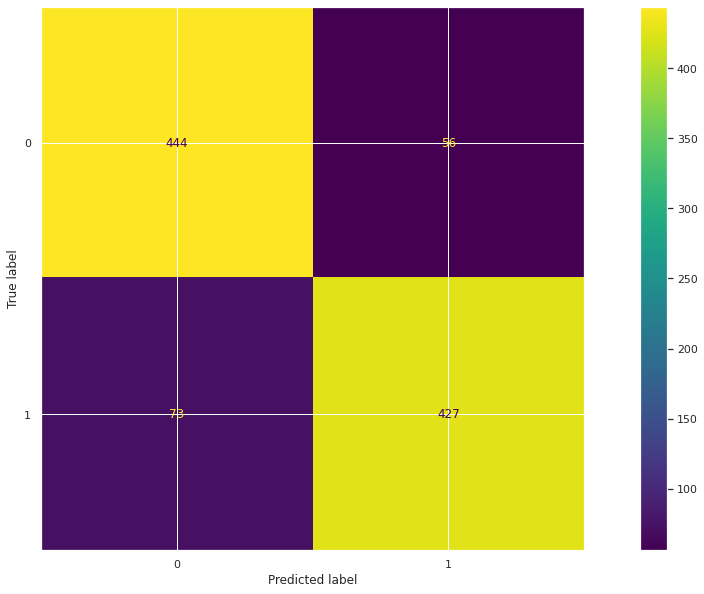

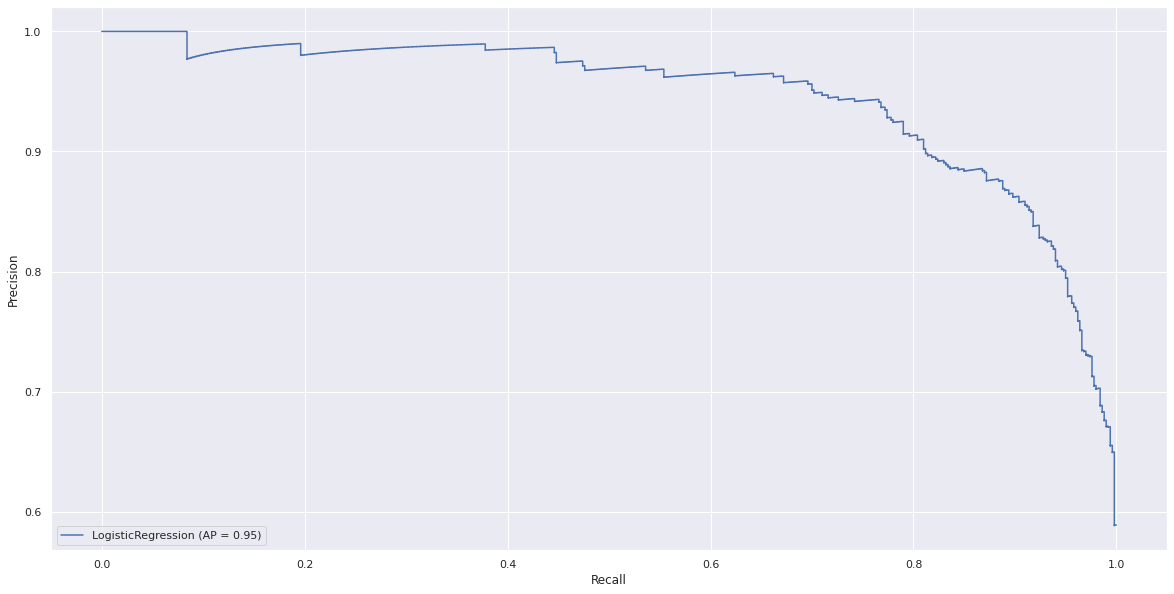

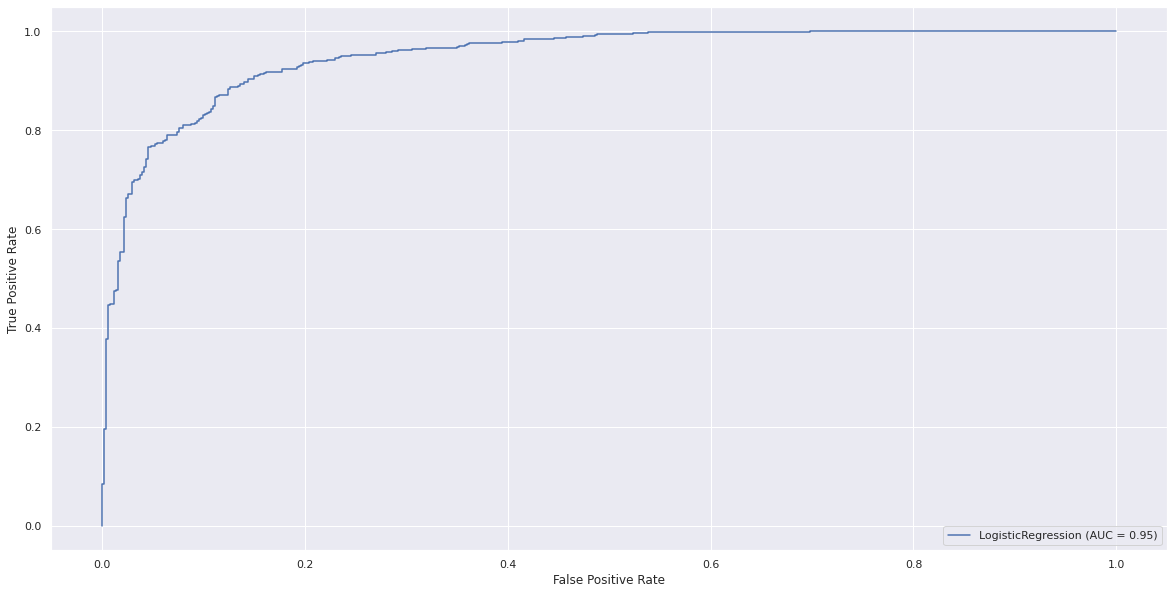

In [16]:
model,coverter = review_predictor.base(data)

> Everything looks great so far 👌

### 📝Test Random Review 📝

### Let's write function for prediction and make it looks simple 🛠

In [17]:
def quick_preictor(text):
    answer = review_predictor.test_sample(text,coverter,model)
    if answer == 'negative':
        print('\033[1m'+'\033[91m'+'Prediction is : '+answer+"\n")
        print(text)
    else:
        print('\033[1m'+'\033[92m'+'Prediction is : '+answer+"\n")
        print(text)

In [18]:
text = 'Purchased this keyboard in September 2018 and it has already stopped working. Some keys do not work while others simply input a gibberish combination of characters. I also purchased the 4 year squaretrade warranty but since it is under the manufacturer warranty they wont allow me to make a claim.'
quick_preictor(text)

Prediction is : negative

Purchased this keyboard in September 2018 and it has already stopped working. Some keys do not work while others simply input a gibberish combination of characters. I also purchased the 4 year squaretrade warranty but since it is under the manufacturer warranty they wont allow me to make a claim.


In [19]:
text = 'Love it just have to sync it up with all the other RGB but love it. Big Razor fan'
quick_preictor(text)

Prediction is : positive

Love it just have to sync it up with all the other RGB but love it. Big Razor fan


In [20]:
text = "I get cold really easy and this jacket is great if you want a warm one. I'm 5'10 and weigh 135lbs and the small fits me well. It has fleece lined pockets and a fleece lined hood. It has a good quality YKK zipper. The coat snaps shut in addition to zippering shut. It has elastic around the wrists for a nice tight fit that won't allow breezes to flow up your arm. There a fleece-line inside pocket about chest high big enough for a cell phone or wallet. It has a velcro enclosure."
quick_preictor(text)

Prediction is : positive

I get cold really easy and this jacket is great if you want a warm one. I'm 5'10 and weigh 135lbs and the small fits me well. It has fleece lined pockets and a fleece lined hood. It has a good quality YKK zipper. The coat snaps shut in addition to zippering shut. It has elastic around the wrists for a nice tight fit that won't allow breezes to flow up your arm. There a fleece-line inside pocket about chest high big enough for a cell phone or wallet. It has a velcro enclosure.


In [21]:
text = "Dont do it ! It will tell u steps and heartbeat .. But dont bother connecting it to your phone 👎 Not android anyways."
quick_preictor(text)

Prediction is : negative

Dont do it ! It will tell u steps and heartbeat .. But dont bother connecting it to your phone 👎 Not android anyways.


In [22]:
text = "I have owned two Samsung smartwatches, one Fitbit, and a new Apple watch 6 for wife, but I am looking for a simple, light, long battery life particularly with Alexa control function smart device. I finally made decision to try it. It took less than 5 minutes to setup EVERYTHING. The screen is beautiful, super crisp text. The Alexa function works perfectly even without the ability of speaker. I can read text message, and get phone call notification. It has a lot of basic health fitness tracker features that are very useful. I would give it 5+ stars."
quick_preictor(text)

Prediction is : positive

I have owned two Samsung smartwatches, one Fitbit, and a new Apple watch 6 for wife, but I am looking for a simple, light, long battery life particularly with Alexa control function smart device. I finally made decision to try it. It took less than 5 minutes to setup EVERYTHING. The screen is beautiful, super crisp text. The Alexa function works perfectly even without the ability of speaker. I can read text message, and get phone call notification. It has a lot of basic health fitness tracker features that are very useful. I would give it 5+ stars.


In [23]:
text = "The WATCH is awesome! Does what i need it to do. Counts my steps and my calories while doing my workout.The battery life is great! Better than my previous watch. You can also change the strap with other ones used for other watches."
quick_preictor(text)

Prediction is : positive

The WATCH is awesome! Does what i need it to do. Counts my steps and my calories while doing my workout.The battery life is great! Better than my previous watch. You can also change the strap with other ones used for other watches.


# END😇

#### I HOPE YOU ENJOY ✌🏻
<div style="width:100%;text-align: center;"> <img align=middle src="https://i2.wp.com/www.thirstydaddy.com/wp-content/uploads/2015/05/thanks-for-reading.png" alt="Heat beating" style="height:300px;margin-top:3rem;"> </div>